# Bonus 4: Implementation of Semi-Supervised Learning through GANs

## Setup

/home/mcreng/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting ./cs231n/datasets/MNIST_data/train-labels-idx1-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ./cs231n/datasets/MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


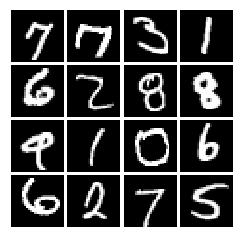

In [1]:
from __future__ import print_function, division
import tensorflow as tf
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# A bunch of utility functions

def show_images(images):
    images = np.reshape(images, [images.shape[0], -1])  # images reshape to (batch_size, D)
    sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
    sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))

    fig = plt.figure(figsize=(sqrtn, sqrtn))
    gs = gridspec.GridSpec(sqrtn, sqrtn)
    gs.update(wspace=0.05, hspace=0.05)

    for i, img in enumerate(images):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(img.reshape([sqrtimg,sqrtimg]))
    return

def preprocess_img(x):
    return 2 * x - 1.0

def deprocess_img(x):
    return (x + 1.0) / 2.0

def rel_error(x,y):
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

def count_params():
    """Count the number of parameters in the current TensorFlow graph """
    param_count = np.sum([np.prod(x.get_shape().as_list()) for x in tf.global_variables()])
    return param_count


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

answers = np.load('gan-checks-tf.npz')

from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('./cs231n/datasets/MNIST_data', one_hot=False)

# show a batch
show_images(mnist.train.next_batch(16)[0])

def leaky_relu(x, alpha=0.01):
    """Compute the leaky ReLU activation function.
    
    Inputs:
    - x: TensorFlow Tensor with arbitrary shape
    - alpha: leak parameter for leaky ReLU
    
    Returns:
    TensorFlow Tensor with the same shape as x
    """
    return tf.maximum(x, alpha*x)

def sample_noise(batch_size, dim):
    """Generate random uniform noise from -1 to 1.
    
    Inputs:
    - batch_size: integer giving the batch size of noise to generate
    - dim: integer giving the dimension of the the noise to generate
    
    Returns:
    TensorFlow Tensor containing uniform noise in [-1, 1] with shape [batch_size, dim]
    """
    # TODO: sample and return noise
    return tf.random_uniform([batch_size, dim], -1, 1)

## Solvers from original GAN

In [2]:
# TODO: create an AdamOptimizer for D_solver and G_solver
def get_solvers(learning_rate=2e-4, beta1=0.5):
    """Create solvers for GAN training.
    
    Inputs:
    - learning_rate: learning rate to use for both solvers
    - beta1: beta1 parameter for both solvers (first moment decay)
    
    Returns:
    - D_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    - G_solver: instance of tf.train.AdamOptimizer with correct learning_rate and beta1
    """
    D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1)
    return D_solver, G_solver

## run_a_gan from original GAN
With self-made validation function, and some masking vector for masking labels from mnist dataset.

In [3]:
def validation(sess):
    minibatch, minibatch_y = mnist.test.next_batch(batch_size)
    minibatch_y = tf.one_hot(minibatch_y, 10)

    with tf.variable_scope("") as scope:
        scope.reuse_variables()
        _, logits = discriminator(minibatch)

    prediction = tf.equal(tf.argmax(minibatch_y, 1), tf.argmax(logits[:, 1:], 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32)).eval(session=sess)

    return accuracy

def run_a_gan(sess, G_train_step, G_loss, D_train_step, D_loss, G_extra_step, D_extra_step,\
              accuracy, show_every=250, print_every=50, batch_size=128, num_epoch=10):
    """Train a GAN for a certain number of epochs.
    
    Inputs:
    - sess: A tf.Session that we want to use to run our data
    - G_train_step: A training step for the Generator
    - G_loss: Generator loss
    - D_train_step: A training step for the Generator
    - D_loss: Discriminator loss
    - G_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for generator
    - D_extra_step: A collection of tf.GraphKeys.UPDATE_OPS for discriminator
    - accuracy: Training accuracy
    Returns:
        Nothing
    """
    # compute the number of iterations we need
    max_iter = int(mnist.train.num_examples*num_epoch/batch_size)
    for it in range(max_iter):
        # run a batch of data through the network
        minibatch, minibatch_y = mnist.train.next_batch(batch_size)
        minibatch_y = tf.one_hot(minibatch_y, 10).eval(session=sess)
        batch_z = sample_noise(batch_size, 96).eval(session=sess)
        mask = get_labeled_mask(0.5, batch_size) # Masking 80% of data
        
        train_feed_dict = {x: minibatch, z: batch_z,
                              label: minibatch_y, labeled_mask: mask}
        
        # every show often, show a sample result
        if it % show_every == 0:
            samples = sess.run(G_sample, feed_dict=train_feed_dict)
            fig = show_images(samples[:16])
            plt.show()
            print()
        _, D_loss_curr = sess.run([D_train_step, D_loss], feed_dict=train_feed_dict)
        _, G_loss_curr = sess.run([G_train_step, G_loss], feed_dict=train_feed_dict)
        train_accuracy = accuracy.eval(feed_dict=train_feed_dict, session=sess)

        # print loss every so often.
        # We want to make sure D_loss doesn't go to 0
        if it % print_every == 0:
            print('Iter: {}, D: {:.4}, G: {:.4}, Acc: {:.4}, Val: {:.4}'.format(
                it,D_loss_curr,G_loss_curr,train_accuracy,validation(sess)))
    print('Final images')
    samples = sess.run(G_sample, feed_dict=train_feed_dict)

    fig = show_images(samples[:16])
    plt.show()

# Original GAN setups
But for dicriminator, apart from generating logits, it also returns a feature vector

In [4]:
def generator(z):
    with tf.variable_scope('generator'):
        fc1 = tf.layers.dense(z, 1024, activation=tf.nn.relu)
        bn1 = tf.layers.batch_normalization(fc1, training=True)
        fc2 = tf.layers.dense(bn1, 7*7*128, activation=tf.nn.relu)
        bn2 = tf.layers.batch_normalization(fc2, training=True)
        im = tf.reshape(bn2, (-1, 7, 7, 128))
        convt1 = tf.layers.conv2d_transpose(im, 64, (4,4), 2, 'same', activation=tf.nn.relu)
        bn3 = tf.layers.batch_normalization(convt1, training=True)
        convt2 = tf.layers.conv2d_transpose(bn3, 1, (4,4), 2, 'same', activation=tf.nn.tanh)
        img = tf.reshape(convt2, (-1, 784))
        return img

def discriminator(x):
    with tf.variable_scope("discriminator"):
        x = tf.reshape(x, (-1, 28, 28, 1))
        conv1 = tf.layers.conv2d(x, 32, (5,5), 1, activation=leaky_relu)
        dp1 = tf.layers.dropout(conv1, 0.9)
        pool1 = tf.layers.max_pooling2d(dp1, (2,2), 2)
        conv2 = tf.layers.conv2d(pool1, 64, (5,5), 1, activation=leaky_relu)
        dp2 = tf.layers.dropout(conv2, 0.9)
        pool2 = tf.layers.max_pooling2d(dp2, (2,2), 2)
        flat = tf.layers.flatten(pool2)
        fc = tf.layers.dense(flat, 128, activation=leaky_relu)
        logits = tf.layers.dense(fc, 11)
        return fc, logits


## GAN loss
- D_loss_sup: Supervised Learning Loss for Discriminator (Classification)
- D_loss_unsup: Unsupervised Learning Loss for Discriminator, same as ordinary GANs
- G_loss_1: Unsupervised Learning Loss for Generatorm, same as ordinary GANs
- G_loss_2: Feature comparison

In [5]:
def gan_loss(logits_real, logits_fake, features_real, features_fake, extended_label, labeled_mask):
    """Compute the GAN loss.
    
    Inputs:
    - logits_real: Tensor, shape [batch_size, 1], output of discriminator
        Log probability that the image is real for each real image
    - logits_fake: Tensor, shape[batch_size, 1], output of discriminator
        Log probability that the image is real for each fake image
    - features_real: Tensor, second to last FC output of discriminator,
        Feature tensor of real images
    - features_fake: Tensor, second to last FC output of discriminator,
        Feature tensor of fake images
    - labeled_mask: Tensor, mask vector storing which entry in the minibatch has the label masked
    
    Returns:
    - D_loss: discriminator loss scalar
    - G_loss: generator loss scalar
    - accuracy: Training accuracy scalar
    """
    temp = tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits_real, labels=extended_label) 

    D_loss_sup = tf.reduce_sum(tf.multiply(temp, labeled_mask)) / tf.reduce_sum(labeled_mask)
    
    D_loss_unsup_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_real[:, 0], labels=tf.zeros_like(logits_real[:, 0])))
    
    D_loss_unsup_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake[:, 0], labels=tf.ones_like(logits_fake[:, 0])))
    
    D_loss = D_loss_sup + D_loss_unsup_real + D_loss_unsup_fake
    
    
    G_loss_1 = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=logits_fake[:, 0],labels=tf.zeros_like(logits_fake[:, 0])))
    
    data_moments = tf.reduce_mean(features_real, axis=0)
    sample_moments = tf.reduce_mean(features_fake, axis=0)
    G_loss_2 = tf.reduce_mean(tf.square(data_moments-sample_moments))
    
    G_loss = G_loss_1 + G_loss_2
    
    prediction = tf.equal(tf.argmax(logits_real[:, 1:], 1), tf.argmax(extended_label[:, 1:], 1))
    accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))
    
    return D_loss, G_loss, accuracy



## Original GAN setup
With some helper functions

In [6]:
# Mask certain data pairs
def get_labeled_mask(labeled_rate, batch_size):
    labeled_mask = np.zeros([batch_size], dtype=np.float32)
    labeled_count = np.int(batch_size * labeled_rate)
    labeled_mask[range(labeled_count)] = 1.0
    np.random.shuffle(labeled_mask)
    return labeled_mask

# Extend ordinary label with one more slot stating whether the image is fake or real
def prepare_extended_label(label):
    return tf.concat([tf.zeros([tf.shape(label)[0], 1]), label], axis = 1)

In [7]:
tf.reset_default_graph()

# number of images for each batch
batch_size = 128
# our noise dimension
noise_dim = 96

# placeholder for images from the training dataset
x = tf.placeholder(tf.float32, [None, 784])
# random noise fed into our generator
z = sample_noise(batch_size, noise_dim)

label = tf.placeholder(tf.float32, shape = [None, 10])
extended_label = prepare_extended_label(label)
labeled_mask = tf.placeholder(tf.float32, shape = [None])

# generated images
G_sample = generator(z)

with tf.variable_scope("") as scope:
    #scale images to be -1 to 1
    features_real, logits_real = discriminator(preprocess_img(x))
    # Re-use discriminator weights on new inputs
    scope.reuse_variables()
    features_fake, logits_fake = discriminator(G_sample)

# Get the list of variables for the discriminator and generator
D_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'discriminator')
G_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 'generator') 

# get our solver
D_solver, G_solver = get_solvers()

# get our loss
D_loss, G_loss, accuracy = gan_loss(logits_real, logits_fake, features_real, features_fake, extended_label, labeled_mask)

# setup training steps
D_train_step = D_solver.minimize(D_loss, var_list=D_vars)
G_train_step = G_solver.minimize(G_loss, var_list=G_vars)
D_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'discriminator')
G_extra_step = tf.get_collection(tf.GraphKeys.UPDATE_OPS, 'generator')

## Training

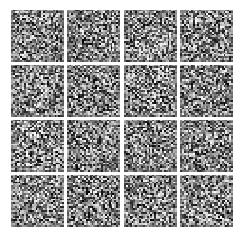


Iter: 0, D: 3.758, G: 0.6915, Acc: 0.125, Val: 0.125
Iter: 50, D: 1.434, G: 2.311, Acc: 0.7812, Val: 0.3516
Iter: 100, D: 1.303, G: 2.45, Acc: 0.9219, Val: 0.4609
Iter: 150, D: 1.293, G: 1.536, Acc: 0.875, Val: 0.5703
Iter: 200, D: 1.168, G: 2.136, Acc: 0.8828, Val: 0.5625


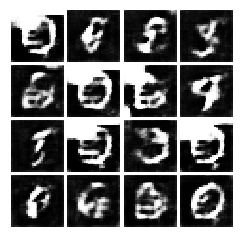


Iter: 250, D: 1.116, G: 1.451, Acc: 0.9609, Val: 0.5469
Iter: 300, D: 1.186, G: 1.496, Acc: 0.9062, Val: 0.6562
Iter: 350, D: 1.27, G: 1.735, Acc: 0.9297, Val: 0.5938
Iter: 400, D: 1.346, G: 1.19, Acc: 0.9375, Val: 0.5469
Iter: 450, D: 1.861, G: 2.03, Acc: 0.8906, Val: 0.6641


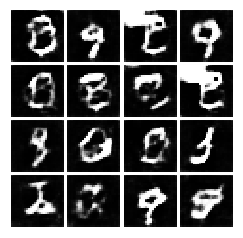


Iter: 500, D: 1.241, G: 1.005, Acc: 0.9688, Val: 0.7188
Iter: 550, D: 1.19, G: 1.171, Acc: 0.9609, Val: 0.5859
Iter: 600, D: 1.594, G: 0.5392, Acc: 0.9453, Val: 0.6719
Iter: 650, D: 1.271, G: 0.9364, Acc: 0.9375, Val: 0.7734
Iter: 700, D: 1.351, G: 1.324, Acc: 0.9609, Val: 0.6562


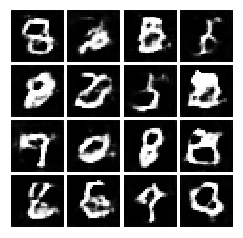


Iter: 750, D: 1.419, G: 1.396, Acc: 0.9766, Val: 0.6172
Iter: 800, D: 1.374, G: 1.128, Acc: 0.9453, Val: 0.7266
Iter: 850, D: 1.287, G: 0.7858, Acc: 0.9453, Val: 0.6875
Iter: 900, D: 1.441, G: 0.8972, Acc: 0.9609, Val: 0.7344
Iter: 950, D: 1.341, G: 0.856, Acc: 0.9609, Val: 0.7109


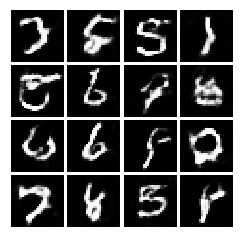


Iter: 1000, D: 1.314, G: 0.8766, Acc: 0.9844, Val: 0.6719
Iter: 1050, D: 1.335, G: 1.026, Acc: 0.9609, Val: 0.6406
Iter: 1100, D: 1.401, G: 0.9712, Acc: 0.9766, Val: 0.7422
Iter: 1150, D: 1.497, G: 1.035, Acc: 0.9766, Val: 0.6953
Iter: 1200, D: 1.371, G: 0.9944, Acc: 0.9688, Val: 0.7734


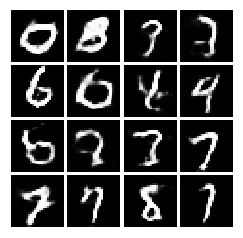


Iter: 1250, D: 1.359, G: 0.6747, Acc: 0.9688, Val: 0.7109
Iter: 1300, D: 1.346, G: 0.6823, Acc: 0.9688, Val: 0.75
Iter: 1350, D: 1.367, G: 0.7605, Acc: 0.9688, Val: 0.7578
Iter: 1400, D: 1.357, G: 0.6936, Acc: 0.9844, Val: 0.7422
Iter: 1450, D: 1.434, G: 0.738, Acc: 0.9531, Val: 0.7812


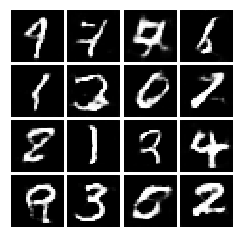


Iter: 1500, D: 1.472, G: 0.9641, Acc: 0.9766, Val: 0.7109
Iter: 1550, D: 1.454, G: 1.084, Acc: 0.9688, Val: 0.6875
Iter: 1600, D: 1.444, G: 0.5285, Acc: 0.9844, Val: 0.7734
Iter: 1650, D: 1.367, G: 0.7085, Acc: 0.9688, Val: 0.7344
Iter: 1700, D: 1.331, G: 0.8905, Acc: 0.9844, Val: 0.6953


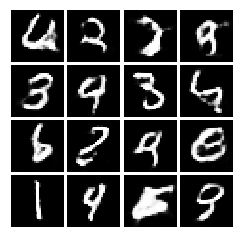


Iter: 1750, D: 1.768, G: 0.8257, Acc: 0.9219, Val: 0.7188
Iter: 1800, D: 1.436, G: 1.128, Acc: 0.9609, Val: 0.7031
Iter: 1850, D: 1.338, G: 0.6356, Acc: 1.0, Val: 0.7969
Iter: 1900, D: 1.403, G: 0.6889, Acc: 0.9844, Val: 0.7656
Iter: 1950, D: 1.471, G: 0.5752, Acc: 0.9688, Val: 0.7734


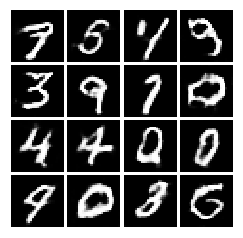


Iter: 2000, D: 1.475, G: 0.5646, Acc: 0.9688, Val: 0.7812
Iter: 2050, D: 1.433, G: 0.5588, Acc: 0.9688, Val: 0.8203
Iter: 2100, D: 1.546, G: 1.229, Acc: 0.9922, Val: 0.6797
Final images


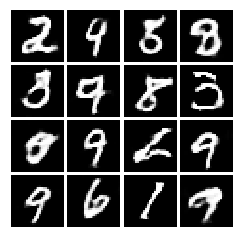

In [8]:
try:    
    sess = get_session()
    sess.run(tf.global_variables_initializer())
    run_a_gan(sess,G_train_step,G_loss,D_train_step,D_loss,G_extra_step,D_extra_step,accuracy,num_epoch=5)
except KeyboardInterrupt:
    print('Stopping training...')

## Results
This displays the results of the semi-supvervised GAN model. I believe if I tune the hyperparameters more, it can go up to 90%+, but training a good GAN is really time-consuming. I am satisfied with this 80% accuracy network.

Final Accuracy: 0.8046875


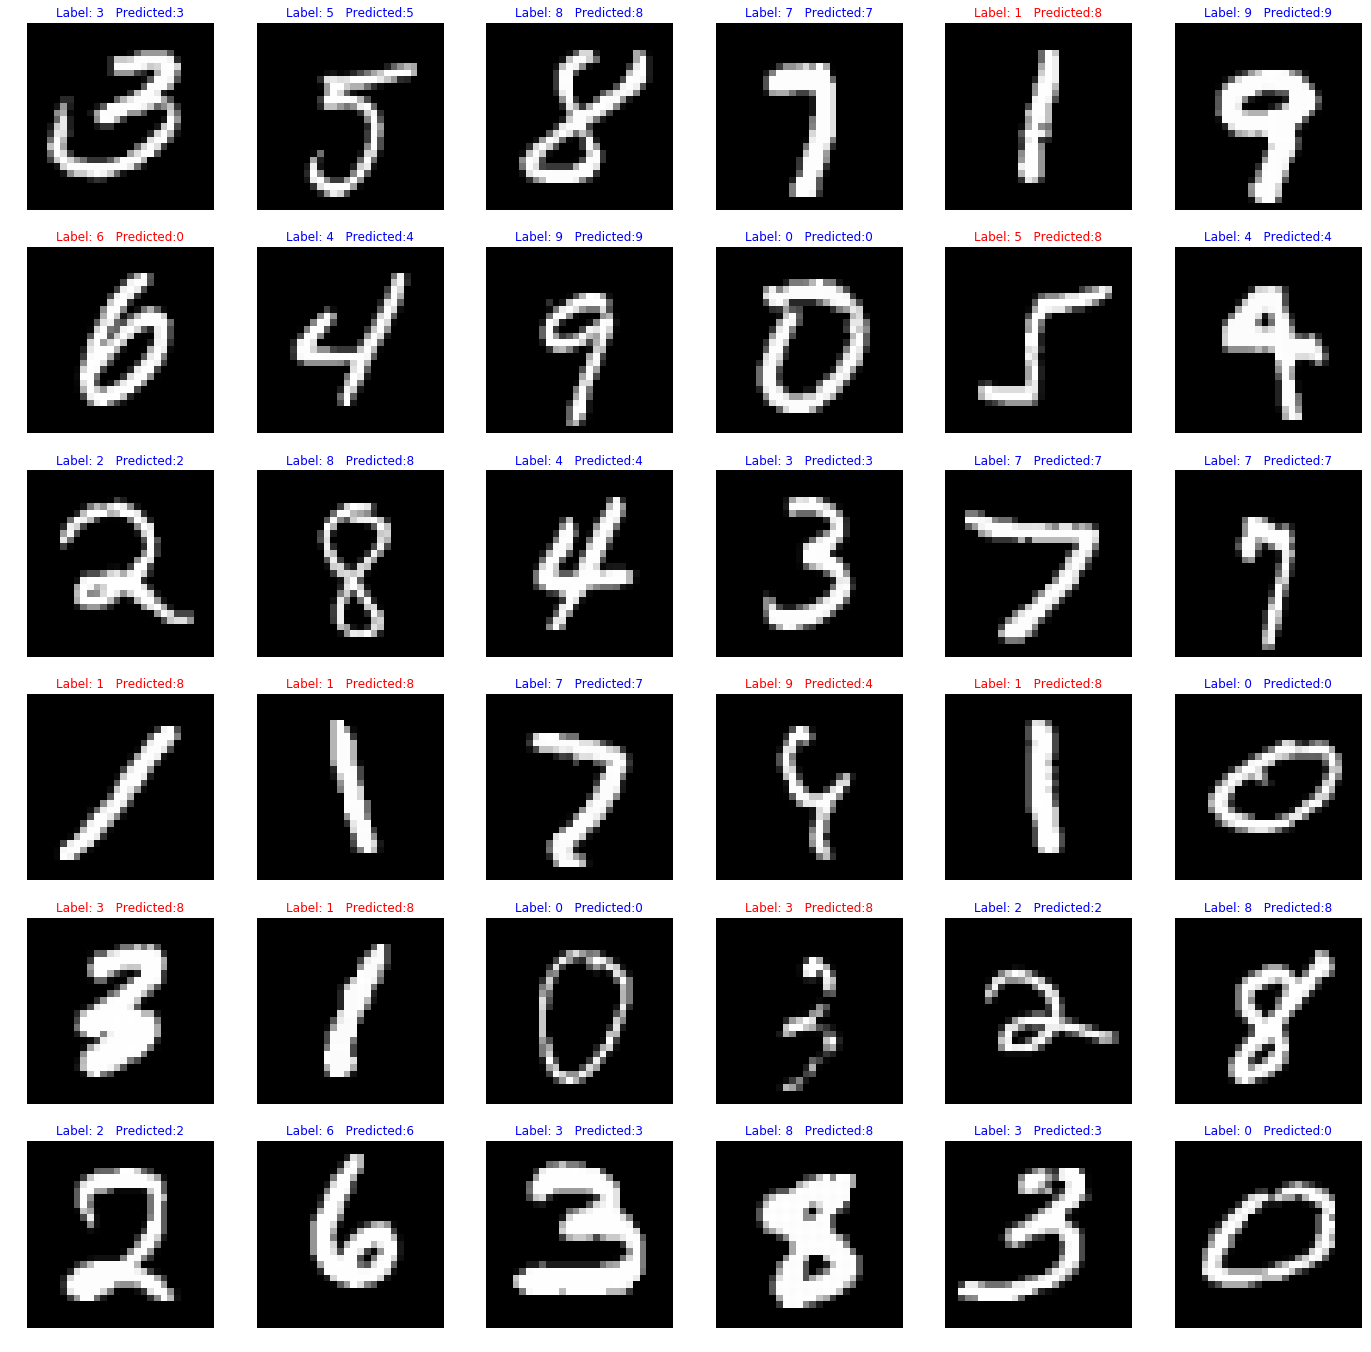

In [28]:
minibatch, minibatch_y = mnist.test.next_batch(batch_size)

with tf.variable_scope("") as scope:
    scope.reuse_variables()
    _, logits = discriminator(minibatch)
    

logits = tf.argmax(logits[:, 1:], -1).eval(session=sess)

prediction = tf.cast(tf.equal(minibatch_y, logits), tf.float32)
accuracy = tf.reduce_mean(prediction)

print('Final Accuracy:', accuracy.eval(session=sess))

num_rows = 6
num_cols = 6
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.axis('off')
    plt.imshow(minibatch[i].reshape(28,28))
    color = 'blue' if minibatch_y[i] == logits[i] else 'red'
    plt.title('Label: ' + str(minibatch_y[i]) + '   Predicted:' + str(logits[i]), color=color)